# RLiable RL

In [1]:
import numpy as np
from visualization.utils import make_defaults, wandb2df, get_track_and_states_df, plot_states
from visualization.utils import defaults as d
from helpers.paths import Path
import pandas as pd
from rliable import library as rly
from rliable import metrics
from rliable import plot_utils

import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
make_defaults()

np.random.seed(0)

In [2]:
# Load scores
IQM = lambda x: metrics.aggregate_iqm(x) # Interquartile Mean
OG = lambda x: metrics.aggregate_optimality_gap(-x, 0) # Optimality Gap
MEAN = lambda x: metrics.aggregate_mean(x)
MEDIAN = lambda x: metrics.aggregate_median(x)

In [3]:
# Load all data
exp1_sac = pd.read_csv(Path().data / 'exp1_reference_signals_50if8s9r_summary.csv')
exp1_dsac = pd.read_csv(Path().data / 'exp1_reference_signals_7xn8j40b_summary.csv')
exp2_sac = pd.read_csv(Path().data / 'exp2_noise_1dt2cxqq_summary.csv')
exp2_dsac = pd.read_csv(Path().data / 'exp2_noise_73376dn5_summary.csv')
exp3_sac_de = pd.read_csv(Path().data / 'exp3_fault_fp41w198_summary.csv')
exp3_dsac_de = pd.read_csv(Path().data / 'exp3_fault_wartuvh0_summary.csv')
exp3_sac_da = pd.read_csv(Path().data / 'exp3_fault_ciavee5i_summary.csv')
exp3_dsac_da = pd.read_csv(Path().data / 'exp3_fault_ckektqy3_summary.csv')

## DSAC and SAC data

In [4]:
all_nmae = {
  'SAC-only': [],
  'DSAC-only': [],
  'SAC-hybrid': [],
  'DSAC-hybrid': [],
}

# Experiment 1
exp1_sac_nmae = exp1_sac[['sac_model', 'task_train', 'eval/nmae']].groupby(['task_train', 'sac_model']).mean()

for task in exp1_sac_nmae.index.levels[0]:
  all_nmae['SAC-only'].append(exp1_sac_nmae.loc[task, 'eval/nmae'].values)

exp1_dsac_nmae = exp1_dsac[['sac_model', 'task_train', 'eval/nmae']].groupby(['task_train', 'sac_model']).mean()

for task in exp1_dsac_nmae.index.levels[0]:
  all_nmae['DSAC-only'].append(exp1_dsac_nmae.loc[task, 'eval/nmae'].values)

# Experiment 2
exp2_sac_nmae = exp2_sac.groupby(['sac_model'])['eval/nmae'].mean().values
all_nmae['SAC-only'].append(exp2_sac_nmae)
exp2_dsac_nmae = exp2_dsac.groupby(['sac_model'])['eval/nmae'].mean().values
all_nmae['DSAC-only'].append(exp2_dsac_nmae)

# Experiment 3
exp3_sac_de_nmae = exp3_sac_de.groupby(['sac_model'])['eval/nmae'].mean().values
all_nmae['SAC-only'].append(exp3_sac_de_nmae)
exp3_sac_da_nmae = exp3_sac_da.groupby(['sac_model'])['eval/nmae'].mean().values
all_nmae['SAC-only'].append(exp3_sac_da_nmae)
exp3_dsac_de_nmae = exp3_dsac_de.groupby(['sac_model'])['eval/nmae'].mean().values
all_nmae['DSAC-only'].append(exp3_dsac_de_nmae)
exp3_dsac_da_nmae = exp3_dsac_da.groupby(['sac_model'])['eval/nmae'].mean().values
all_nmae['DSAC-only'].append(exp3_dsac_da_nmae)


In [5]:
# Hybrids

# Experiment 1
for task in exp1_sac['task_train'].unique():
    all_nmae['SAC-hybrid'].append(
        exp1_sac[exp1_sac['task_train'] == task]['online/nmae'].values
    )
    all_nmae['DSAC-hybrid'].append(
        exp1_dsac[exp1_dsac['task_train'] == task]['online/nmae'].values
    )

# Experiment 2
all_nmae['SAC-hybrid'].append(exp2_sac['online/nmae'].values)
all_nmae['DSAC-hybrid'].append(exp2_dsac['online/nmae'].values)

# Experiment 3
all_nmae['SAC-hybrid'].append(exp3_sac_de['online/nmae'].values)
all_nmae['SAC-hybrid'].append(exp3_sac_da['online/nmae'].values)
all_nmae['DSAC-hybrid'].append(exp3_dsac_de['online/nmae'].values)
all_nmae['DSAC-hybrid'].append(exp3_dsac_da['online/nmae'].values)

In [6]:

# Transform all values of all_nmae into np.array
all_nmae_scalled = all_nmae.copy()
for k, v in all_nmae.items():
  all_nmae_scalled[k] = np.array(v).T * 100

In [7]:
all_nmae_scalled

{'SAC-only': array([[21.49048753,  7.75118766, 14.55064965, 14.54918099, 14.30814465,
         16.95892153],
        [17.7253184 ,  9.84683196, 15.77954919, 15.77978317, 21.48725811,
         34.42169506],
        [21.11880846, 15.84801025, 19.57835883, 19.57775286, 19.58143194,
         34.24605572]]),
 'DSAC-only': array([[27.21355608, 19.90260396, 25.44628746, 25.44623998, 29.30220572,
         33.68929925],
        [12.96898925,  1.44345501,  5.33160605,  5.32907481,  6.38627606,
          6.64912335],
        [27.42939774, 18.866884  , 25.43682113, 25.43696807, 31.60089186,
         45.6928175 ]]),
 'SAC-hybrid': array([[ 5.1780455 , 15.6013391 ,  6.39851394,  3.80149927,  4.04394618,
          7.14991511],
        [ 4.01260924, 14.97718216,  6.43355171,  3.67502722,  5.83080403,
         12.09685965],
        [ 4.10584342, 15.96255879,  6.34581152,  3.45205843,  4.38224774,
          7.63786432],
        [ 4.26035195, 15.19782449,  7.43404098,  4.47541617,  4.85383043,
          

# Stratified Bootstrap confidence interval

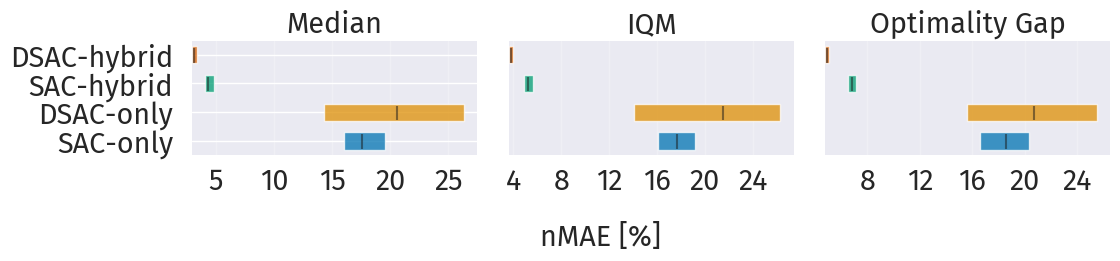

In [16]:
aggregate_func = lambda x: np.array([MEDIAN(x), IQM(x), OG(x)])
aggregate_scores, aggregate_interval_estimates = rly.get_interval_estimates(
    all_nmae_scalled, aggregate_func, reps=50000)
algorithms = ["SAC-only", "DSAC-only", "SAC-hybrid", "DSAC-hybrid"]
colors = dict(zip(algorithms, sns.color_palette('colorblind')))
fig, axes = plot_utils.plot_interval_estimates(
    aggregate_scores,
    aggregate_interval_estimates,
    metric_names = ['Median', 'IQM', 'Optimality Gap'],
    algorithms=algorithms,
    xlabel_y_coordinate=-0.5,
    max_ticks=6,
    colors=colors,
    xlabel='nMAE [%]')

plt.show()
if True:
    fig.savefig(f"{str(Path().paper_figures)}/rliable-metrics.pdf", bbox_inches='tight')

# Performance profile

In [9]:
# nmae metric should be minimized
def mean_score_deviation(scores: np.ndarray, tau: float) -> float:
  """Evaluates how many average task `scores` are bellow `tau`."""
  return np.mean(np.mean(scores, axis=0) < tau)

average_score_distributions = np.vectorize(mean_score_deviation, excluded=[0])

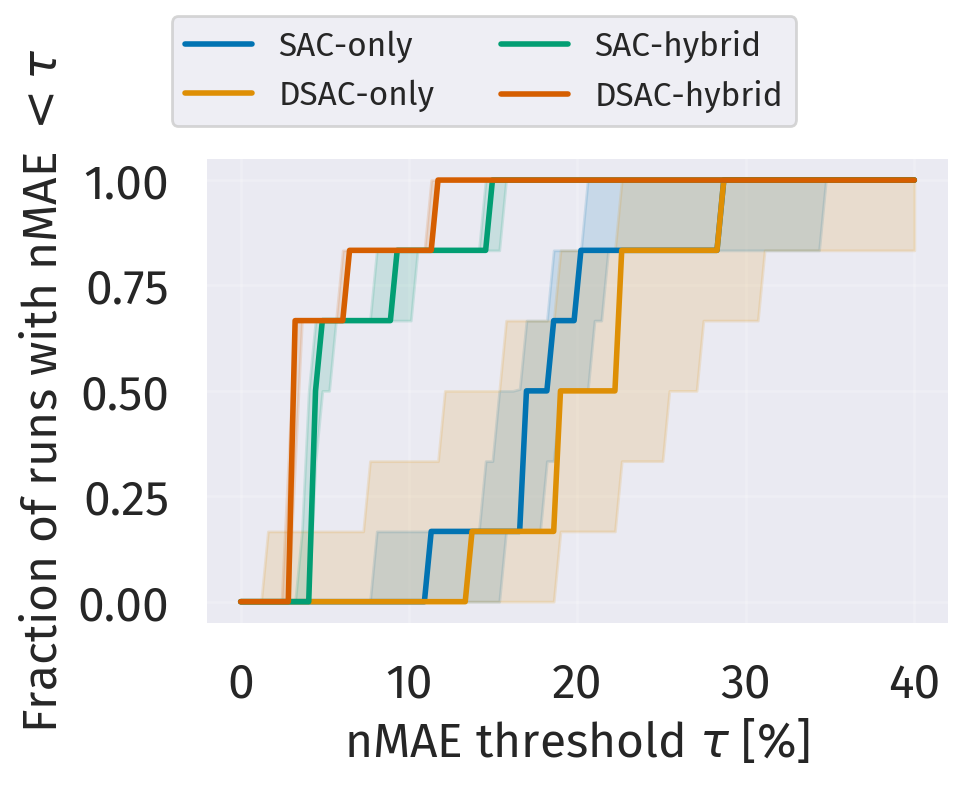

In [10]:
thresholds = np.linspace(0.0, 40, 100)
score_distributions, score_distributions_cis = rly.create_performance_profile(
    all_nmae_scalled, thresholds,
custom_profile_func=average_score_distributions)
# Plot score distributions
fig, ax = plt.subplots(ncols=1, figsize=(5, 4), dpi=200)
plot_utils.plot_performance_profiles(
  score_distributions, thresholds,
  performance_profile_cis=score_distributions_cis,
  colors=dict(zip(algorithms, sns.color_palette('colorblind'))),
  xlabel=r'nMAE threshold $\tau$ [%]',
    ylabel=r'Fraction of runs with nMAE $< \tau$',
  ax=ax,
)

fig.legend(loc='upper center', ncol=2, fontsize=12)
plt.tight_layout(
    rect=[0, 0, 1, 0.85]
)  # adjust the rectangle in which to fit the subplots
plt.show()
if True:
    fig.savefig(f"{str(Path().paper_figures)}/rliable-profile.pdf", bbox_inches='tight')

## Probability of improvement

In [11]:
def probability_of_improvement(scores_x: np.ndarray, scores_y: np.ndarray):
  """Overall Probability of imporvement of algorithm `X` over `Y`.

  Args:
    scores_x: A matrix of size (`num_runs_x` x `num_tasks`) where scores_x[n][m]
      represent the score on run `n` of task `m` for algorithm `X`.
    scores_y: A matrix of size (`num_runs_y` x `num_tasks`) where scores_x[n][m]
      represent the score on run `n` of task `m` for algorithm `Y`.
  Returns:
      P(X_m > Y_m) averaged across tasks.
  """
  import scipy
  num_tasks = scores_x.shape[1]
  task_improvement_probabilities = []
  num_runs_x, num_runs_y = scores_x.shape[0], scores_y.shape[0]
  for task in range(num_tasks):
    if np.array_equal(scores_x[:, task], scores_y[:, task]):
      task_improvement_prob = 0.5
    else:
      task_improvement_prob, _ = scipy.stats.mannwhitneyu(
          scores_x[:, task]*-1, scores_y[:, task]*-1, alternative='less')
      task_improvement_prob /= (num_runs_x * num_runs_y)
    task_improvement_probabilities.append(task_improvement_prob)
  return np.mean(task_improvement_probabilities)



pairs = [["DSAC-hybrid", "SAC-hybrid"],
         ["DSAC-hybrid", "SAC-only"],
         ["DSAC-hybrid", "DSAC-only"],
         ["SAC-hybrid", "SAC-only"],
         ["SAC-hybrid", "DSAC-only"],
         ["SAC-only", "DSAC-only"]]

pairs_scores = {}
for pair in pairs[::-1]:
  d1 = all_nmae_scalled[pair[0]]
  d2 = all_nmae_scalled[pair[1]]
  # d_concat = np.concatenate((d1, d2), axis=-1)
  pairs_scores[','.join(pair)] = (d1, d2)


probabilities, probability_cis = rly.get_interval_estimates(
    pairs_scores, probability_of_improvement, reps=2000)

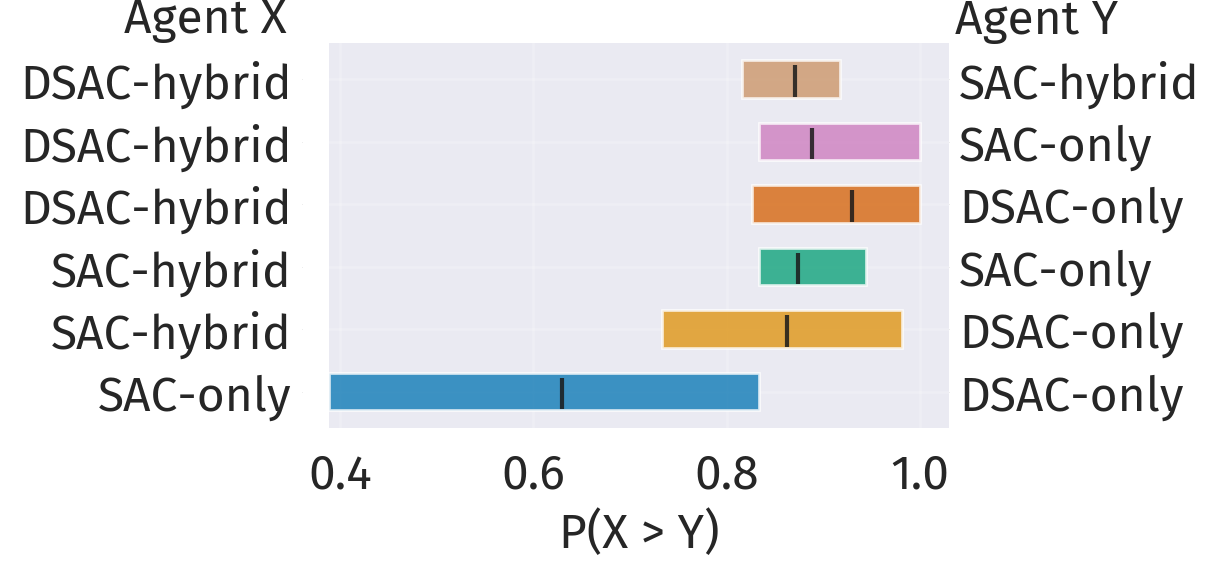

In [12]:
fig, ax = plt.subplots(ncols=1, figsize=(4, 2.5), dpi=200)
plot_utils.plot_probability_of_improvement(probabilities, probability_cis,
                                           ax=ax,
                                           left_ylabel='Agent X',
                                           right_ylabel='Agent Y',)
# plt.tight_layout()
plt.show()
if True:
    fig.savefig(f"{str(Path().paper_figures)}/rliable-improvement.pdf", bbox_inches='tight')